<a href="https://colab.research.google.com/github/juDEcorous/Sales_Predictions/blob/main/Project_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **SALES PREDICTION** </center>

Jude Maico Jr.

# Data Dictionary

## Imports

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector 
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# models [!] Some are added for experementing models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

import joblib

# Data Loading

In [2]:
df = pd.read_csv('sales_predictions.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

# Data Cleaning

## Duplicates

In [3]:
print(f'we have a total number/s of {df.duplicated().sum()} duplicates.')

we have a total number/s of 0 duplicates.


## Missing Values

In [4]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

It shows that we dont have a missing values in our Target which is Item_Outlet_Sales.

# Inconsistencies

In [5]:
data_types = df.dtypes
obj_data = data_types[(data_types == 'object')]

for column in obj_data.index:
  print(column)
  print(f'Unique Values: {df[column].unique()}\n')

Item_Identifier
Unique Values: ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

Item_Fat_Content
Unique Values: ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

Item_Type
Unique Values: ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier
Unique Values: ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size
Unique Values: ['Medium' nan 'High' 'Small']

Outlet_Location_Type
Unique Values: ['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type
Unique Values: ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [6]:
#Fixing inconsistencies in column Item_Fat_Content
df.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [7]:
fat_content_map = {'LF':'Low Fat',
                   'low fat':'Low Fat',
                   'reg':'Regular'}
            
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(fat_content_map)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [8]:
y = df['Item_Outlet_Sales']
X = df.drop(columns = ['Item_Outlet_Sales', 'Item_Identifier'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Numerical Features

In [9]:
#Column Selector
number_selector = make_column_selector(dtype_include = 'number')

#Transformers
#Standard Scaler
scaler = StandardScaler()
#Imputers
median_imputer = SimpleImputer(strategy = 'median')

#Pipeline
number_pipeline = make_pipeline(median_imputer, scaler)

#tuples
number_tuples = (number_pipeline, number_selector)

## Nominal Features

In [10]:
nominal_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type']

ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
missing_imputer = SimpleImputer(strategy = 'constant', fill_value = 'missing')

nominal_pipeline = make_pipeline(missing_imputer, ohe)

nominal_tuples = (nominal_pipeline, nominal_columns)

## Ordinal Features

In [11]:
#Categorical list
Outlet_Size_list = ['Small', 'Medium', 'High']
Outlet_Type_list = ['Grocery Store', 'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3']

ordinal_columns = ['Outlet_Size', 'Outlet_Type']

ordinal_encoder = OrdinalEncoder(categories = [Outlet_Size_list, Outlet_Type_list])
freq_imputer = SimpleImputer(strategy = 'most_frequent')
scaler2 = StandardScaler()

ordinal_pipeline = make_pipeline(freq_imputer, ordinal_encoder, scaler2)

ordinal_tuples = (ordinal_pipeline, ordinal_columns)

In [12]:
#Instantiate the make column transformer
preprocessor = make_column_transformer(number_tuples,
                                       nominal_tuples,
                                       ordinal_tuples,
                                       remainder = 'drop',
                                       verbose_feature_names_out = False)

In [13]:
# Fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()


X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
7503     0.341372        -0.776646 -0.998816                  -1.293807   
2957    -1.169135         0.100317 -1.585194                  -0.102145   
7031     0.388798        -0.482994 -1.595784                   0.136187   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
7503                       1.0                       0.0   
2957                       1.0                       0.0   
7031                       0.0                       1.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
7503                     0.0               0.0                  0.0   
2957                     0.0               0.0                  0.0   
7031                     0.0               0.0                  0.0   

      Item_Type_Canned  ...  Outlet_Identifier_OUT027  \
7503               0.0  ...                       0.0   
2957               0.0  ...                       0.0   
7031               1.0  ...                       0.0   

      Outlet_Identifier_OUT035  Outlet_Identifier_OUT045  \
7503                       0.0                       0.0   
2957                       0.0                       0.0   
7031                       0.0                       0.0   

      Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  \
7503                       0.0                       0.0   
2957                       1.0                       0.0   
7031                       0.0                       1.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
7503                          0.0                          0.0   
2957                          1.0                          0.0   
7031                          1.0                          0.0   

      Outlet_Location_Type_Tier 3  Outlet_Size  Outlet_Type  
7503                          1.0     1.958796      -0.2636  
2957                          0.0    -1.384048      -0.2636  
7031                          0.0     0.287374      -0.2636  

[3 rows x 37 columns]

# Feature Importance

In [14]:
def plot_coeffs(coeffs, top_n = None, figsize=(4,5), 
                intercept = False, intercept_name = "intercept", 
                annotate = False, ha = 'left', va = 'center', size = 12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending = False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel = 'Coefficient', 
            ylabel = 'Feature Names', 
            title = title)
    ax.axvline(0, color = 'k')
    if annotate == True:
        annotate_hbars(ax, ha = ha, va = va, size = size, 
                       xytext = xytext, textcoords = textcoords)
    return ax

def annotate_hbars(ax, ha = 'left', va = 'center', size = 12, xytext = (4,0),
                  textcoords = 'offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha = ha, va = va, size = size,
                        xytext = xytext, textcoords = textcoords)

In [15]:
#storing metrics
metrics_df = pd.DataFrame()

## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe, X_train, y_train, X_test, y_test, model_name):
    
    ## Predictions
    train_pred = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)
    
    ## Metrics DF
    metrics_df.at[(f'{model_name}'), 
                  'Train MAE'] = round(mean_absolute_error(y_train, train_pred),4)
    metrics_df.at[(f'{model_name}'), 
                  'Test MAE'] = round(mean_absolute_error(y_test, test_preds),4)
    metrics_df.at[(f'{model_name}'), 
                  'Train RMSE'] = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
    metrics_df.at[(f'{model_name}'), 
                  'Test RMSE'] = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
    metrics_df.at[(f'{model_name}'), 
                  'Train r2'] = round(r2_score(y_train, train_pred),4)
    metrics_df.at[(f'{model_name}'), 
                  'Test r2'] = round(r2_score(y_test, test_preds),4)
    
    display(metrics_df.iloc[::-1])

In [28]:
def tuning(X_train, y_train, X_test, y_test, 
           model_pipe, model_params, model_name):
    grid = GridSearchCV(model_pipe, model_params)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_model.fit(X_train, y_train)
    
    train_pred = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    # Metrics DF
    metrics_df.at[(f'{model_name}'), 
                  'Train MAE'] = round(mean_absolute_error(y_train, train_pred),4)
    metrics_df.at[(f'{model_name}'), 
                  'Test MAE'] = round(mean_absolute_error(y_test, test_preds),4)
    metrics_df.at[(f'{model_name}'), 
                  'Train RMSE'] = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
    metrics_df.at[(f'{model_name}'), 
                  'Test RMSE'] = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
    metrics_df.at[(f'{model_name}'), 
                  'Train r2'] = round(r2_score(y_train, train_pred),4)
    metrics_df.at[(f'{model_name}'), 
                  'Test r2'] = round(r2_score(y_test, test_preds),4)
    
    display(metrics_df)

In [17]:
def plot_importance_color_ax(importances, top_n = None,  figsize = (8,6), 
                          color_dict = None, ax = None):
    
    # sorting with asc=false for correct order of bars
    if top_n == None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind = 'barh', figsize = figsize, color = colors, ax = ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind = 'barh', figsize = figsize, ax = ax)
        
    # set titles and axis labels
    ax.set(xlabel = 'Importance', 
           ylabel = 'Feature Names', 
           title = title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

## Linear Regression Model

In [18]:
linear = LinearRegression()
linear.fit(X_train_df, y_train)
model_metrics(linear, X_train_df, y_train, X_test_df, y_test, 
              'Linear Regression')

Train MAE  Test MAE  Train RMSE  Test RMSE  Train r2  \
Linear Regression   847.2173  804.1506   1139.1201  1092.7266    0.5615   

                   Test r2  
Linear Regression   0.5672

In [19]:
coeffs = pd.Series(linear.coef_, index = preprocessor.get_feature_names_out())
coeffs.loc['intercept'] = linear.intercept_
coeffs

Item_Weight                       -8.102974e+00
Item_Visibility                   -2.186020e+01
Item_MRP                           9.845419e+02
Outlet_Establishment_Year         -3.723238e+14
Item_Fat_Content_Low Fat           4.935367e+14
Item_Fat_Content_Regular           4.935367e+14
Item_Type_Baking Goods             2.857939e+14
Item_Type_Breads                   2.857939e+14
Item_Type_Breakfast                2.857939e+14
Item_Type_Canned                   2.857939e+14
Item_Type_Dairy                    2.857939e+14
Item_Type_Frozen Foods             2.857939e+14
Item_Type_Fruits and Vegetables    2.857939e+14
Item_Type_Hard Drinks              2.857939e+14
Item_Type_Health and Hygiene       2.857939e+14
Item_Type_Household                2.857939e+14
Item_Type_Meat                     2.857939e+14
Item_Type_Others                   2.857939e+14
Item_Type_Seafood                  2.857939e+14
Item_Type_Snack Foods              2.857939e+14
Item_Type_Soft Drinks              2.857

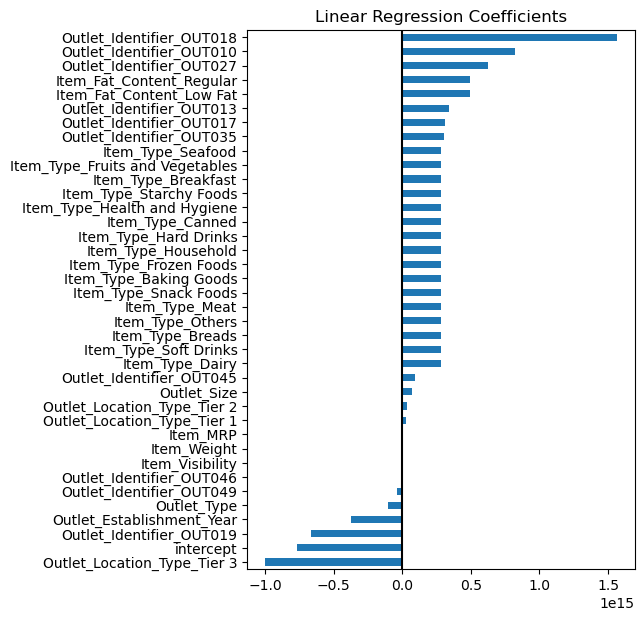

In [20]:
ax = coeffs.sort_values().plot(kind = 'barh', figsize = (5,7))
ax.axvline(0,color = 'k')
ax.set_title('Linear Regression Coefficients');

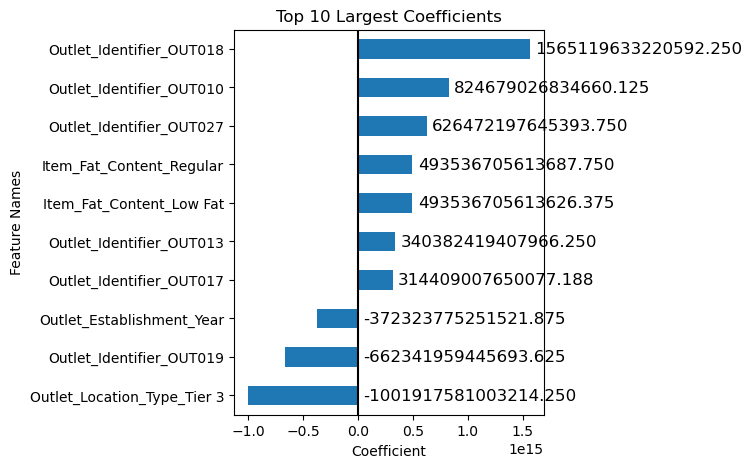

In [21]:
# # Visualizing the Most Impactful Coefficients
# coeff_rank = coeffs.abs().rank().sort_values(ascending = False) 
# top_n_features = coeff_rank.head(10) # Only the top 10
# top_n = 10
# plot_vals = coeffs.loc[top_n_features.index] # Slicing out the top_n_features names to visualize

plot_coeffs(coeffs, top_n = 10, intercept = False, annotate = True); # False annotate because it is giving big numbers

- The Coefficients shows that the Outlet_Identifier will increase the sales of the Outlet Stores. These following Outlet Identifiers will increase the Bargain Sales:
    1. Outlet018
    2. Outllet010
    3. Outlet027
   

## Random Forest Model

In [22]:
ran_for = RandomForestRegressor(random_state = 42)
ran_for.fit(X_train_df, y_train)
model_metrics(ran_for, X_train_df, y_train, X_test_df, y_test, 
              'Random Forest')

Train MAE  Test MAE  Train RMSE  Test RMSE  Train r2  \
Random Forest       296.2560  766.1894    427.2466  1102.8774    0.9383   
Linear Regression   847.2173  804.1506   1139.1201  1092.7266    0.5615   

                   Test r2  
Random Forest       0.5591  
Linear Regression   0.5672

In [29]:
ran_for_pipe = make_pipeline(preprocessor, ran_for)
tuning(X_train_df, y_train, X_test_df, y_test, 
       ran_for_pipe, 
       {'randomforestregressor__n_estimators' : range(10, 110, 10),
        'randomforestregressor__max_depth' : range(1, 11)},
      'Tuned Random Forest')

ValueError: 
All the 500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Item_Fat_Content'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\utils\__init__.py", line 416, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    raise KeyError(key) from err
KeyError: 'Item_Fat_Content'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\compose\_column_transformer.py", line 687, in fit_transform
    self._validate_column_callables(X)
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\compose\_column_transformer.py", line 374, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "C:\Users\j29ma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\utils\__init__.py", line 424, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [24]:
# Feature Importance
rf_feature_importance = pd.Series(ran_for.feature_importances_, 
                                  index = feature_names)

In [25]:
# Permutation Importance#
rf_r = permutation_importance(ran_for, X_test_df, y_test,n_repeats = 5)
rf_permutation_importances = pd.Series(rf_r['importances_mean'],
                                       index = X_test_df.columns)

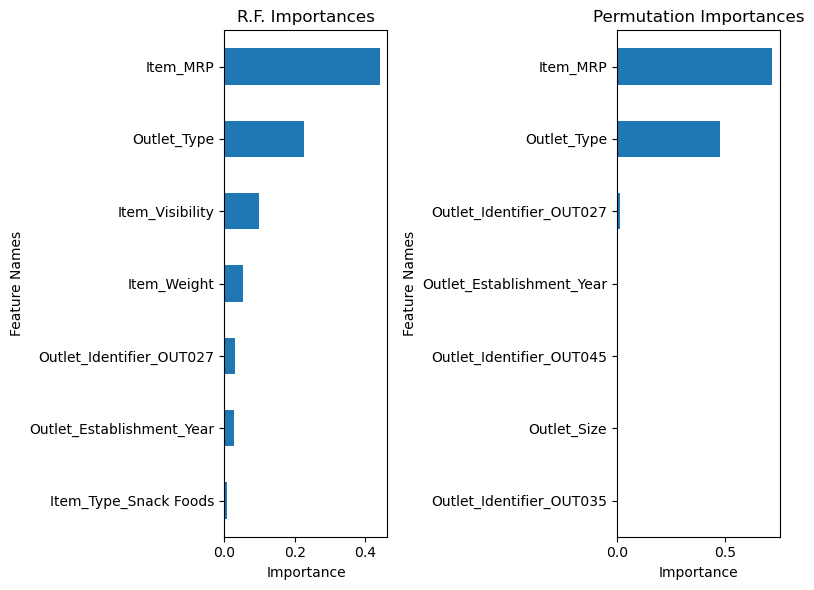

In [26]:
# [!] COLOR_DICT is removed for now, still could not figure that one out

fig, axes = plt.subplots(ncols = 2)
n = 7 # setting the # of features to use for both subplots
plot_importance_color_ax(rf_feature_importance, top_n = n, ax = axes[0])
plot_importance_color_ax(rf_permutation_importances, top_n = n, ax = axes[1])
axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()

- Both Feature and Permutation has 'Item_MRP' and 'Outlet_Type' as their top 2 Importance.
- 'Outlet_Identifier_OUT27' is also seen as top 5 for both Feature and Permutation. BUt in different position.

In [27]:
export = {'preprocessor': preprocessor,
          'X_train':X_train_df,
          'y_train': y_train,
          'X_test':X_test_df,
          'y_test': y_test,
          'LinearRegression': linear,
          'RandomForestRegressor': ran_for}
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']